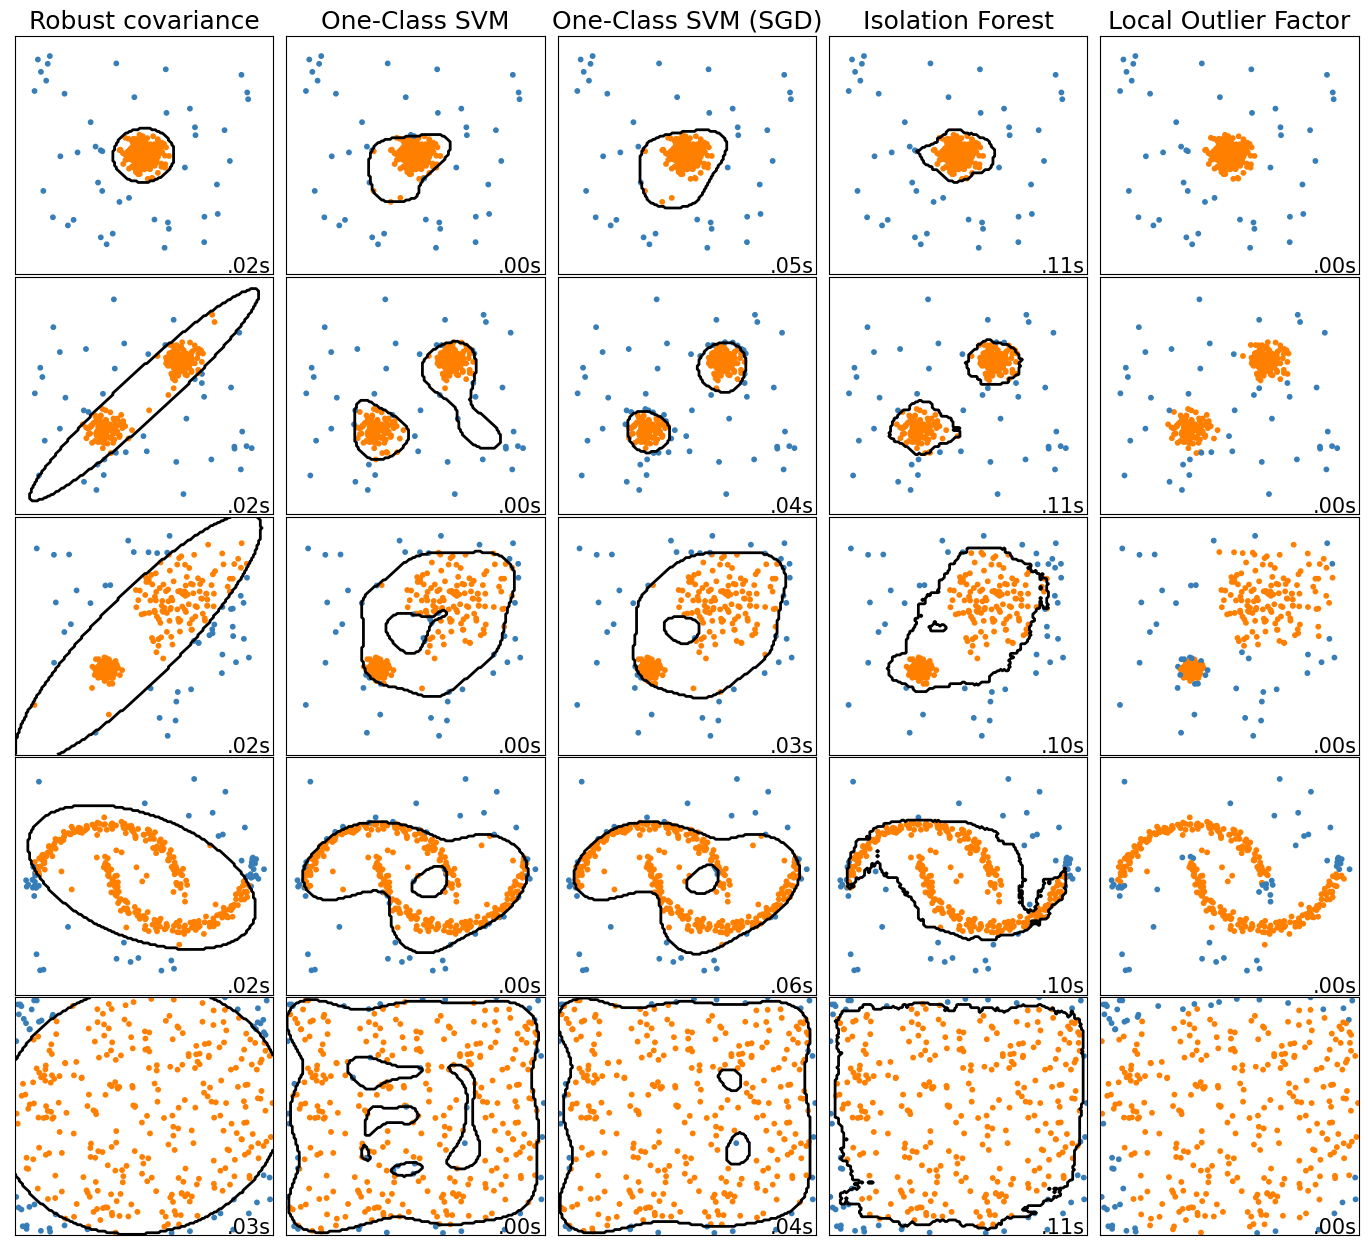

In [1]:

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs, make_moons
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
# 시각화 설정을 조정합니다.
matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# 예제 설정: 샘플 수, 이상치 비율, 이상치 수, 정상 데이터 수를 정의합니다.
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# 비교할 이상치/안정성 탐지 방법을 정의합니다. SGDOneClassSVM은 커널 근사와 함께 파이프라인에서 사용되어야 합니다.
anomaly_algorithms = [
    (
        "Robust covariance",
        EllipticEnvelope(contamination=outliers_fraction, random_state=42),
    ),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]
# 비교할 분류기를 설정합니다. 여기서 xx, yy는 시각화를 위한 메쉬그리드입니다.
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)
# 각 데이터셋에 대해 이상치 탐지 알고리즘을 적용하고 결과를 시각화합니다.
for i_dataset, X in enumerate(datasets):
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        if name != "Local Outlier Factor": 
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()